from https://blog.csdn.net/i_am_huang/article/details/89207102

HBOS（Histogram-based Outlier Score）是一种原理简单，且通常很有效的无监督算法。该方法为每一个样本进行异常评分，评分越高越可能是异常点。评分模型为：

​                                       ![img](pics/20190411120114845.png)

假设样本*p*第 *i* 个特征的概率密度为 ，则*p*的概率密度可以计算为：

​                                       ![img](pics/20190411120208338.png)

两边取对数：

​                                    ![img](pics/20190411120222673.png)

概率密度越大，异常评分越小，则两边乘以“-1”：

​                                  ![img](pics/20190411120244826.png)

即：

​                                   ![img](pics/20190411120259269.png)

如何计算概率密度，特别是对于连续型数据？最简单的方法是对连续数据进行离散化。离散化的基本思想是设置“断点”，将数据分割成若干个区间。其中，“断点”的设置可以是静态的，也可以是动态的。

对于样本集***D\***，设置合适的“断点”集合，将特征的取值分割成若干个区间。统计区间的样本数，可以构建一个频数直方图***H\***。假设第 *i* 个特征分割成*m* 个区间，每个区间统计的样本个数分别为：

​                                              ![img](pics/20190411120316587.png)

频率（概率）分布表

| 取值 | 区间1                              | 区间2                              | ...... | 区间*m*                            |
| ---- | ---------------------------------- | ---------------------------------- | ------ | ---------------------------------- |
| 频率 | ![img](pics/20190411120358264.png) | ![img](pics/20190411120344607.png) | ...... | ![img](pics/20190411120426856.png) |

明显，根据频数直方图***H\***可以计算出所有特征的频率分布。

为什么频率越大，异常评分越小？

​                                   ![img](pics/20190411120438486.png)

​                                            特征*c*

上图是特征*c*的样本分布例图。直观上，B样本是异常点，A点是正常点。由于，样本*A*（样本*B*）关于特征*c*的概率密度估计可以用特征*c*在相应区间的频率来近似。显然，特征的取值频率越大，样本的关于该特征的异常评分越小。

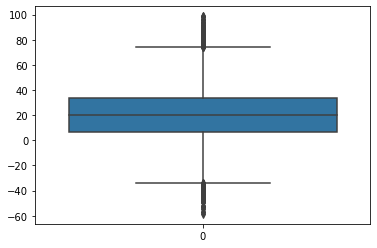

In [2]:
import pyod
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data = np.random.randn(50000) * 20 + 20
sns.boxplot(data=data)


On Training Data:
HBOS ROC:0.9947, precision @ rank n:0.8

On Test Data:
HBOS ROC:0.9744, precision @ rank n:0.6


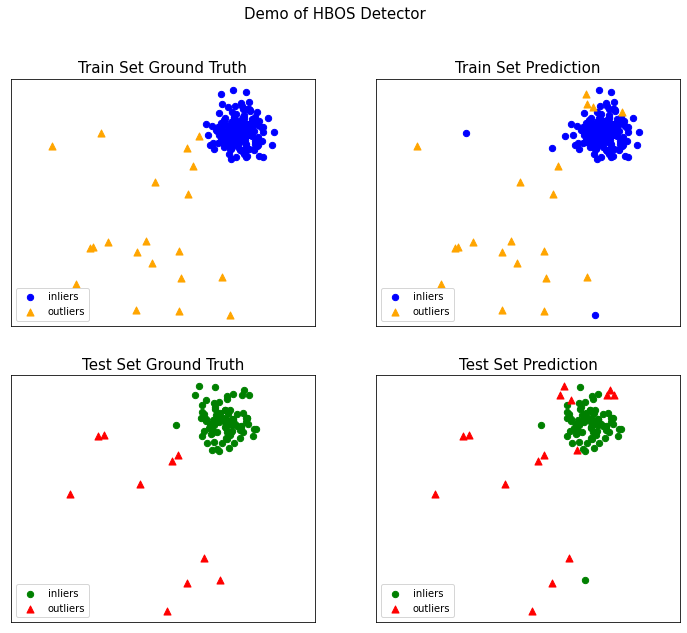

In [4]:
# -*- coding: utf-8 -*-
"""Example of using Histogram- based outlier detection (HBOS) for
outlier detection
"""
# Author: No Ashamed Copy from Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause
import matplotlib.pyplot as plt
from pyod.models.hbos import HBOS
from pyod.utils.data import generate_data, generate_data_clusters
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

# if __name__ == "__main__":
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                    n_test=n_test,
                    n_features=2,
                    contamination=contamination,
                    random_state=42)

# train HBOS detector
clf_name = 'HBOS'
clf = HBOS()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=False)

In [6]:
x_outliers, x_inliers = pyod.utils.data.get_outliers_inliers(X_test,y_test)
n_inliers = len(x_inliers)
n_outliers = len(x_outliers)
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

print(classification_report(y_true=y_train,y_pred=y_train_pred))
print(classification_report(y_true=y_test,y_pred=y_test_pred))

fpr, tpr, thersholds = roc_curve(y_test, y_test_pred, pos_label=2)
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))

# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
# plt.xlim([-1, 2])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
# plt.ylim([-1, 2])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
# plt.title('ROC Curve')
# plt.legend(loc="lower right")
# plt.show()

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       180
         1.0       0.80      0.80      0.80        20

    accuracy                           0.96       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.96      0.96      0.96       200

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95        90
         1.0       0.56      0.90      0.69        10

    accuracy                           0.92       100
   macro avg       0.78      0.91      0.82       100
weighted avg       0.95      0.92      0.93       100

0.000000 nan 2.000000
0.160000 nan 1.000000
1.000000 nan 0.000000
C:\Users\jonxia\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


由上图看到，模型效果并不是很好，那么就开始调参
![](pics/2-1.jpg)
参数列表为：
- n_bins (int, optional (default=10)) – The number of bins.

- alpha (float in (0, 1), optional (default=0.1)) – The regularizer for preventing overflow.

- tol (float in (0, 1), optional (default=0.5)) – The parameter to decide the flexibility while dealing the samples falling outside the bins.

- contamination (float in (0., 0.5), optional (default=0.1)) – The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function.

默认参数为：n_bins=10, alpha=0.1, tol=0.5, contamination=0.1


On Training Data:
HBOS ROC:1.0, precision @ rank n:1.0

On Test Data:
HBOS ROC:1.0, precision @ rank n:1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       180
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        90
         1.0       0.91      1.00      0.95        10

    accuracy                           0.99       100
   macro avg       0.95      0.99      0.97       100
weighted avg       0.99      0.99      0.99       100



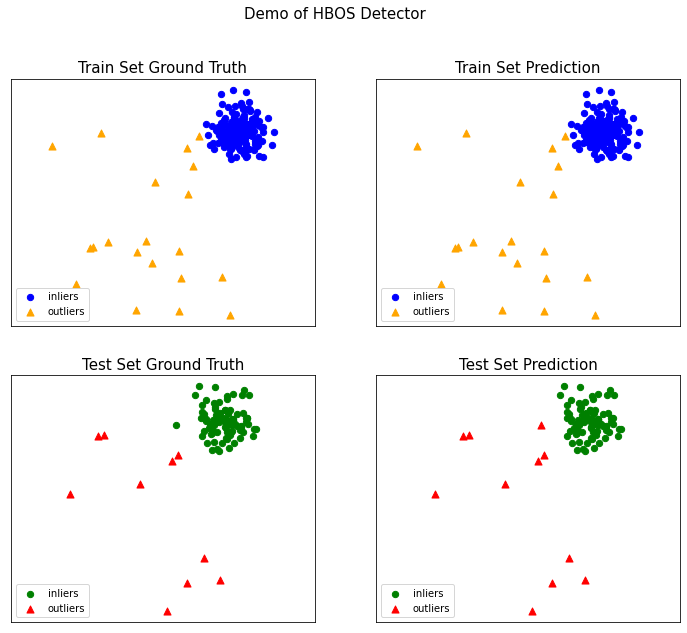

In [8]:
# train HBOS detector
clf_name = 'HBOS'
clf = HBOS(n_bins=6, 
            alpha=0.1, 
            tol=0.5, 
            contamination=0.1)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)
print(classification_report(y_true=y_train,y_pred=y_train_pred))
print(classification_report(y_true=y_test,y_pred=y_test_pred))
# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=False)

减少bins或者减少alpha都可以提高在工业界梦寐以求的结果，虽然这个是toy example……希望datawhale以后能有好的数据集做一期od的实战学习


On Training Data:
HBOS ROC:0.9513, precision @ rank n:0.5294

On Test Data:
HBOS ROC:0.9735, precision @ rank n:0.6923


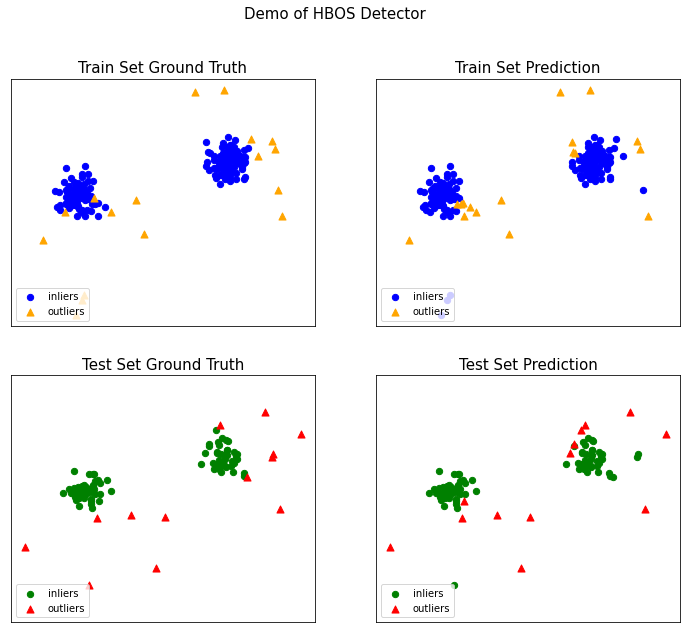

In [10]:
# if __name__ == "__main__":
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train,X_test, y_train,  y_test = \
    generate_data_clusters(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                #   n_clusters=2,
                  contamination=contamination,
                  random_state=42)
# print(X_test)
# train HBOS detector
clf_name = 'HBOS'
# clf = HBOS(n_bins=122,
#             alpha=0.09, 
#             tol=0.5, 
#             contamination=0.2)
clf = HBOS(n_bins=10
            # alpha=0.09, 
            # tol=0.5, 
            # contamination=0.1
            )
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores


# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=False)

n_bins对准确率影响较大，alpha影响较小
测试了，2簇和3簇的数据集之后发现，以上结论正确，且：n_bins在数据集越复杂的时候需要加大，alpha在此之上可以对过拟合进行优化，但是train和test之间差别并不大，此参数提高有限，另两个参数有待研究